# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [2]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

14936


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [3]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [4]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [5]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\figures.


## 1.2 setting up plotting parameters

In [6]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [7]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [8]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook

## Codebook

Example of [codebook](../../postanalysis/0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [9]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Load Transcription summary


Data below can be generated by the notebook:

[0_locus_annotation/scripts/5_majortype_atac_and_rna_means_by_loci](../0_locus_annotation/scripts/5_majortype_atac_and_rna_means_by_loci.ipynb)

In [12]:
import tqdm
sel_class_list = ['Gluta','GABA','Oligo','Astro','Endo','Micro']
ref_measure_dict_byGroup = {}

for _class in tqdm.tqdm(sel_class_list):
    _class_name = _class.replace(' ','_').replace('/','_')
    #print(_class_name)
    rna_atac_fname = os.path.join(output_analysis_folder,f'MajorType_{_class_name}_snATAC_snRNA_mean_by_loci.csv')
    if os.path.exists(rna_atac_fname):
        rna_atac_df = pd.read_csv(rna_atac_fname,index_col=0)
        ref_measure_dict_byGroup[_class] = rna_atac_df

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 162.19it/s]


In [13]:
rna_atac_df

,loci_name,mean_ATAC_2X_2000kb,mean_rna_2X_2000kb,mean_rna_2X_200kb
0,chr1_3742742_3759944,1.391338,0.907407,0.462963
1,chr1_6245958_6258969,1.774731,1.925926,0.777778
2,chr1_8740008_8759916,2.144798,3.240741,0.000000
3,chr1_9627926_9637875,2.246028,2.759259,0.870370
4,chr1_9799472_9811359,2.271399,2.759259,0.703704
...,...,...,...,...
1977,chrX_166247682_166259932,2.507688,2.870370,0.666667
1978,chrX_167157164_167167452,2.485648,3.314815,1.870370
1979,chrX_168746045_168757590,2.334956,3.351852,0.574074
1980,chrX_169963295_170005197,0.875705,1.407407,0.000000


# 4. Load ABcompartment binary

Data below can be generated by the notebook as

[2_ab_compartment_assignment_threshold_zero](2_ab_compartment_assignment_threshold_zero.ipynb)

In [15]:
group_ABs_id_df = pd.read_csv(os.path.join(output_analysis_folder,'AB_assignment_shared_ABth_zero.csv'), index_col=0)
group_ABs_id_df

,Astro,Endo,GABA,Gluta,Micro,Oligo
loci_name,,,,,,
chr1_3742742_3759944,B,B,B,B,B,B
chr1_6245958_6258969,A,B,B,B,B,B
chr1_8740008_8759916,B,B,B,B,B,B
chr1_9627926_9637875,A,B,B,B,A,B
chr1_9799472_9811359,A,B,B,B,A,A
...,...,...,...,...,...,...
chrX_163750534_163758706,A,A,A,A,A,A
chrX_166247682_166259932,A,A,A,A,A,A
chrX_167157164_167167452,A,A,A,A,A,A


# 5. Plot ABcompartment summary

## AB summary across celltypes

In [16]:
res_summary_dict = {}
for _group in group_ABs_id_df.columns:
    _group_AB_id  = group_ABs_id_df[_group]
    res_summary_dict[_group]={'A': np.sum(_group_AB_id=='A'),'B': np.sum(_group_AB_id=='B')}
res_summary_df = pd.DataFrame(res_summary_dict).transpose()
res_summary_df['celltype'] = res_summary_df.index
res_summary_df['total'] = res_summary_df['A']+res_summary_df['B']
res_summary_df

,A,B,celltype,total
Astro,919,994,Astro,1913
Endo,940,850,Endo,1790
GABA,860,1053,GABA,1913
Gluta,911,1070,Gluta,1981
Micro,902,1011,Micro,1913
Oligo,882,972,Oligo,1854


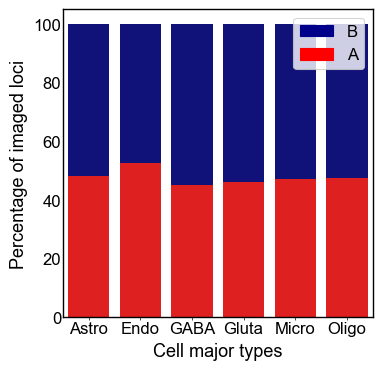

In [17]:
%matplotlib inline
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(4,4))

# from raw value to percentage
total = res_summary_df.copy(deep=True)
A_frac = res_summary_df.copy(deep=True)
total['ratio'] = [i / j * 100 for i,j in zip(total['total'], total['total'])]
A_frac['ratio'] = [i / j * 100 for i,j in zip(A_frac['A'], total['total'])]

#total = total[~total.index.str.contains('HiC')]
#A_frac = A_frac[~A_frac.index.str.contains('HiC')]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="celltype",  y="ratio", data=total, color='darkblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="celltype", y="ratio", data=A_frac, color='red')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='B')
bottom_bar = mpatches.Patch(color='red', label='A')
plt.legend(handles=[top_bar, bottom_bar],fontsize=12)

ax.tick_params('x', labelsize=12, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=True) # remove bottom ticklabels for _ax
ax.tick_params('y', labelsize=12, 
                    width=_ticklabel_width, length=0,
                    pad=1, labelleft=True)
        
ax.set_ylabel('Percentage of imaged loci', fontsize=13)
ax.set_xlabel('Cell major types', fontsize=13)
# show the graph

#plt.savefig(os.path.join(output_figure_folder,f'ABcompartment_percentage_summary_majorType.pdf'),
                    #transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)
plt.show()

## AB changes between celltypes

In [18]:
sorted_chroms = [f'chr{i}' for i in range(1,20)]
sorted_chroms.append('chrX')
#sorted_chroms

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_14936\1292777759.py:17: RuntimeWarning: invalid value encountered in long_scalars
  change_summary_dict['A to A'].append(np.sum((_group_1_AB_chr=='A') & (_group_2_AB_chr=='A'))/total_AB_chr)
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_14936\1292777759.py:18: RuntimeWarning: invalid value encountered in long_scalars
  change_summary_dict['B to B'].append(np.sum((_group_1_AB_chr=='B') & (_group_2_AB_chr=='B'))/total_AB_chr)
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_14936\1292777759.py:19: RuntimeWarning: invalid value encountered in long_scalars
  change_summary_dict['A to B'].append(np.sum((_group_1_AB_chr=='A') & (_group_2_AB_chr=='B'))/total_AB_chr)
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_14936\1292777759.py:20: RuntimeWarning: invalid value encountered in long_scalars
  change_summary_dict['B to A'].append(np.sum((_group_1_AB_chr=='B') & (_group_2_AB_chr=='A'))/total_AB_chr)
meta NOT subset; don't know how to subset; dropp

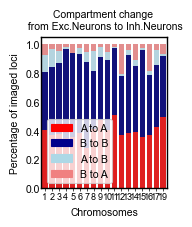

In [19]:
change_summary_dict = {}
_group_1 = 'Gluta'
_group_2 = 'GABA'
#_group_2 = 'Oligo'
#_group_2 = 'Endo'

#chosen_chrom = 'chr1'
AB_change_types = ['A to A','B to B','A to B','B to A',]
change_summary_dict={'A to A':[],'B to B':[],'A to B':[],'B to A':[],'chr':[]}

for chosen_chrom in sorted_chroms:
    group_ABs_id_df_chr = group_ABs_id_df[group_ABs_id_df.index.str.contains(f'{chosen_chrom}_')]
    
    _group_1_AB_chr = np.array(group_ABs_id_df_chr[_group_1].tolist())
    _group_2_AB_chr = np.array(group_ABs_id_df_chr[_group_2].tolist())
    total_AB_chr = np.sum((_group_1_AB_chr!='unassigned') & (_group_2_AB_chr!='unassigned'))
    change_summary_dict['A to A'].append(np.sum((_group_1_AB_chr=='A') & (_group_2_AB_chr=='A'))/total_AB_chr)
    change_summary_dict['B to B'].append(np.sum((_group_1_AB_chr=='B') & (_group_2_AB_chr=='B'))/total_AB_chr)
    change_summary_dict['A to B'].append(np.sum((_group_1_AB_chr=='A') & (_group_2_AB_chr=='B'))/total_AB_chr)
    change_summary_dict['B to A'].append(np.sum((_group_1_AB_chr=='B') & (_group_2_AB_chr=='A'))/total_AB_chr)
    change_summary_dict['chr'].append(chosen_chrom)

change_summary_df = pd.DataFrame(change_summary_dict)
                           
cum_change_summary_df = change_summary_df[AB_change_types].cumsum(axis=1)
cum_change_summary_df['chr'] = change_summary_df['chr']

import matplotlib.patches as mpatches

sel_change_summary_df = cum_change_summary_df.dropna()
sel_change_summary_df = sel_change_summary_df[sel_change_summary_df['chr']!='chrX']

#fig, ax = plt.subplots(figsize=(_page_width/2.8,_page_width/2.8))
fig, ax = plt.subplots(figsize=(_page_width/3.4,_page_width/2.8))

AB_change_types_colors = ['red','darkblue','lightblue','lightcoral']

#bar1 = sns.barplot(x="celltype",  y="ratio", data=total, color='darkblue')
for _col, _color in zip(AB_change_types[::-1], AB_change_types_colors[::-1]):
    bar_col = sns.barplot(x="chr", y=_col, data=sel_change_summary_df, color=_color)

# add legend
_bar_list = []
for _bar_id in range(len(AB_change_types_colors)):
    _bar = mpatches.Patch(color=AB_change_types_colors[_bar_id], label=AB_change_types[_bar_id])
    _bar_list.append(_bar)

plt.legend(handles=_bar_list,fontsize=_font_size, loc='lower left',ncol=1)
#sns.move_legend(ax, "lower left", #bbox_to_anchor=(0.5, 1.15), 
                #ncol=2)


ax.tick_params('x', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=True) # remove bottom ticklabels for _ax
ax.tick_params('y', labelsize=_font_size, 
                    width=_ticklabel_width, length=0,
                    pad=1, labelleft=True)

select_chroms_plot = [i.split('chr')[1] for i in sel_change_summary_df['chr'].tolist()]
#select_chroms_plot.append('X')
#ax.set_xticks(np.arange(0,len(select_chroms_plot)))
TickLabels = select_chroms_plot
ax.set_xticklabels(TickLabels,rotation=0,fontdict={'fontsize':_font_size-1})
    
ax.set_ylabel('Percentage of imaged loci', fontsize=_font_size)
ax.set_xlabel('Chromosomes', fontsize=_font_size)
ax.set_title(f'Compartment change from {_group_1} to {_group_2}', fontsize=_font_size)
ax.set_title(f'Compartment change \n from Exc.Neurons to Inh.Neurons', fontsize=_font_size)
# show the graph
ax.grid(False)


plt.savefig(os.path.join(output_figure_folder,f'ABcompartment_change_from_{_group_1}_to_{_group_2}.pdf'),
                    transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)

plt.show()

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_14936\1152055534.py:17: RuntimeWarning: invalid value encountered in long_scalars
  change_summary_dict['A to A'].append(np.sum((_group_1_AB_chr=='A') & (_group_2_AB_chr=='A'))/total_AB_chr)
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_14936\1152055534.py:18: RuntimeWarning: invalid value encountered in long_scalars
  change_summary_dict['B to B'].append(np.sum((_group_1_AB_chr=='B') & (_group_2_AB_chr=='B'))/total_AB_chr)
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_14936\1152055534.py:19: RuntimeWarning: invalid value encountered in long_scalars
  change_summary_dict['A to B'].append(np.sum((_group_1_AB_chr=='A') & (_group_2_AB_chr=='B'))/total_AB_chr)
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_14936\1152055534.py:20: RuntimeWarning: invalid value encountered in long_scalars
  change_summary_dict['B to A'].append(np.sum((_group_1_AB_chr=='B') & (_group_2_AB_chr=='A'))/total_AB_chr)
meta NOT subset; don't know how to subset; dropp

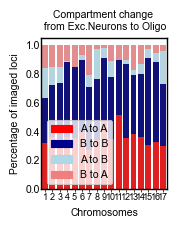

In [20]:
change_summary_dict = {}
_group_1 = 'Gluta'
_group_2 = 'Oligo'
#_group_2 = 'Oligo'
#_group_2 = 'Endo'

#chosen_chrom = 'chr1'
AB_change_types = ['A to A','B to B','A to B','B to A',]
change_summary_dict={'A to A':[],'B to B':[],'A to B':[],'B to A':[],'chr':[]}

for chosen_chrom in sorted_chroms:
    group_ABs_id_df_chr = group_ABs_id_df[group_ABs_id_df.index.str.contains(f'{chosen_chrom}_')]
    
    _group_1_AB_chr = np.array(group_ABs_id_df_chr[_group_1].tolist())
    _group_2_AB_chr = np.array(group_ABs_id_df_chr[_group_2].tolist())
    total_AB_chr = np.sum((_group_1_AB_chr!='unassigned') & (_group_2_AB_chr!='unassigned'))
    change_summary_dict['A to A'].append(np.sum((_group_1_AB_chr=='A') & (_group_2_AB_chr=='A'))/total_AB_chr)
    change_summary_dict['B to B'].append(np.sum((_group_1_AB_chr=='B') & (_group_2_AB_chr=='B'))/total_AB_chr)
    change_summary_dict['A to B'].append(np.sum((_group_1_AB_chr=='A') & (_group_2_AB_chr=='B'))/total_AB_chr)
    change_summary_dict['B to A'].append(np.sum((_group_1_AB_chr=='B') & (_group_2_AB_chr=='A'))/total_AB_chr)
    change_summary_dict['chr'].append(chosen_chrom)

change_summary_df = pd.DataFrame(change_summary_dict)
                           
cum_change_summary_df = change_summary_df[AB_change_types].cumsum(axis=1)
cum_change_summary_df['chr'] = change_summary_df['chr']

import matplotlib.patches as mpatches

sel_change_summary_df = cum_change_summary_df.dropna()
sel_change_summary_df = sel_change_summary_df[sel_change_summary_df['chr']!='chrX']

fig, ax = plt.subplots(figsize=(_page_width/3.4,_page_width/2.8))
AB_change_types_colors = ['red','darkblue','lightblue','lightcoral']

#bar1 = sns.barplot(x="celltype",  y="ratio", data=total, color='darkblue')
for _col, _color in zip(AB_change_types[::-1], AB_change_types_colors[::-1]):
    bar_col = sns.barplot(x="chr", y=_col, data=sel_change_summary_df, color=_color)

# add legend
_bar_list = []
for _bar_id in range(len(AB_change_types_colors)):
    _bar = mpatches.Patch(color=AB_change_types_colors[_bar_id], label=AB_change_types[_bar_id])
    _bar_list.append(_bar)

plt.legend(handles=_bar_list,fontsize=_font_size, loc='lower left',ncol=1)
#sns.move_legend(ax, "lower left", #bbox_to_anchor=(0.5, 1.15), 
                #ncol=2)


ax.tick_params('x', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=True) # remove bottom ticklabels for _ax
ax.tick_params('y', labelsize=_font_size, 
                    width=_ticklabel_width, length=0,
                    pad=1, labelleft=True)

select_chroms_plot = [i.split('chr')[1] for i in sel_change_summary_df['chr'].tolist()]
#select_chroms_plot.append('X')
#ax.set_xticks(np.arange(0,len(select_chroms_plot)))
TickLabels = select_chroms_plot
ax.set_xticklabels(TickLabels,rotation=0,fontdict={'fontsize':_font_size-1})
    
ax.set_ylabel('Percentage of imaged loci', fontsize=_font_size)
ax.set_xlabel('Chromosomes', fontsize=_font_size)
#ax.set_title(f'Compartment change from {_group_1} to {_group_2}', fontsize=_font_size)
ax.set_title(f'Compartment change \n from Exc.Neurons to Oligo', fontsize=_font_size)
# show the graph
ax.grid(False)


plt.savefig(os.path.join(output_figure_folder,f'ABcompartment_change_from_{_group_1}_to_{_group_2}.pdf'),
                    transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)

plt.show()